In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from sklearn.datasets import load_svmlight_file
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import matplotlib.pyplot  as plt

In [2]:
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [5]:
df.duplicated().sum()

np.int64(0)

<Axes: >

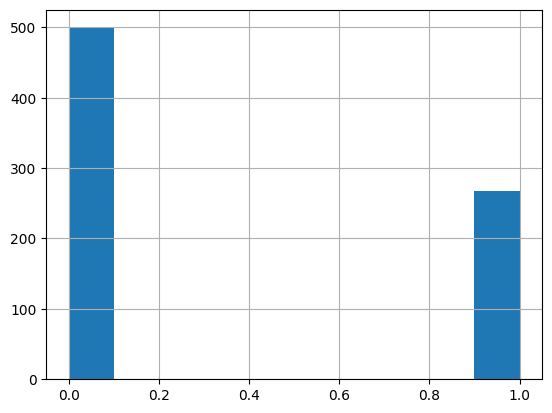

In [6]:
df["Outcome"].hist()

array([[<Axes: title={'center': 'Pregnancies'}>,
        <Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>],
       [<Axes: title={'center': 'SkinThickness'}>,
        <Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'BMI'}>],
       [<Axes: title={'center': 'DiabetesPedigreeFunction'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Outcome'}>]], dtype=object)

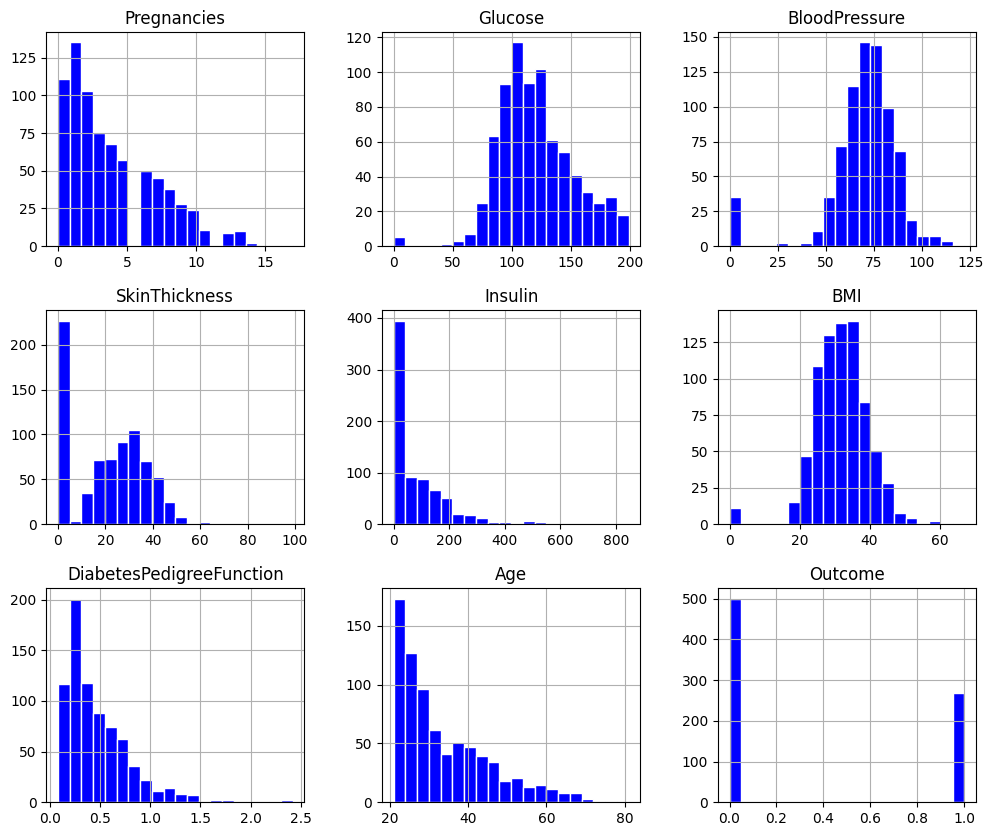

In [7]:
#plotting the histogram of all the features to know the data distribution
df.hist(figsize=(12, 10), bins=20, color='blue', edgecolor='white')

In [8]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [9]:
from sklearn.model_selection import train_test_split

X = df.drop("Outcome",axis=1)
y = df["Outcome"]

X_train_val,X_test,y_train_val,y_test = train_test_split(X,y,test_size=0.2,random_state=42,shuffle=True,stratify=y)
X_train,X_val,y_train,y_val = train_test_split(X_train_val,y_train_val,test_size=0.2,random_state=42,stratify=y_train_val)

print(X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape)

(491, 8) (491,) (123, 8) (123,) (154, 8) (154,)


In [10]:
#scaling the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

In [11]:
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.tensor(X_train_scaled.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.float32)).view(-1, 1)

# Create dataset and dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)

In [12]:
class Perceptron(nn.Module):
    def __init__(self, input_dim):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_dim, 1)  # One output neuron

    def forward(self, x):
        return torch.sigmoid(self.fc(x))


In [13]:
#base model
from torch.optim.lr_scheduler import ExponentialLR

# Initialize the Perceptron with the correct input dimension
base_model = Perceptron(input_dim=X_train.shape[1])
criterion = nn.BCELoss() 
optimizer = optim.SGD(base_model.parameters(), lr=0.001) 


In [14]:
losses = []
def train_model(model,criterion, optimizer, epochs=200):
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(loss.item())

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


In [15]:
train_model(base_model,criterion, optimizer, epochs=200)

Epoch [1/200], Loss: 0.6859
Epoch [2/200], Loss: 0.5888
Epoch [3/200], Loss: 0.7099
Epoch [4/200], Loss: 0.5664
Epoch [5/200], Loss: 0.7276
Epoch [6/200], Loss: 0.6543
Epoch [7/200], Loss: 0.5669
Epoch [8/200], Loss: 0.5045
Epoch [9/200], Loss: 0.6370
Epoch [10/200], Loss: 0.6314
Epoch [11/200], Loss: 0.8087
Epoch [12/200], Loss: 0.6056
Epoch [13/200], Loss: 0.6300
Epoch [14/200], Loss: 0.4857
Epoch [15/200], Loss: 0.6765
Epoch [16/200], Loss: 0.7354
Epoch [17/200], Loss: 0.8387
Epoch [18/200], Loss: 0.6722
Epoch [19/200], Loss: 0.4579
Epoch [20/200], Loss: 0.5960
Epoch [21/200], Loss: 0.5996
Epoch [22/200], Loss: 0.8269
Epoch [23/200], Loss: 0.7408
Epoch [24/200], Loss: 0.5733
Epoch [25/200], Loss: 0.5018
Epoch [26/200], Loss: 0.5094
Epoch [27/200], Loss: 0.5773
Epoch [28/200], Loss: 0.7082
Epoch [29/200], Loss: 0.5196
Epoch [30/200], Loss: 0.5782
Epoch [31/200], Loss: 0.5165
Epoch [32/200], Loss: 0.5295
Epoch [33/200], Loss: 0.5904
Epoch [34/200], Loss: 0.6549
Epoch [35/200], Loss: 0

200


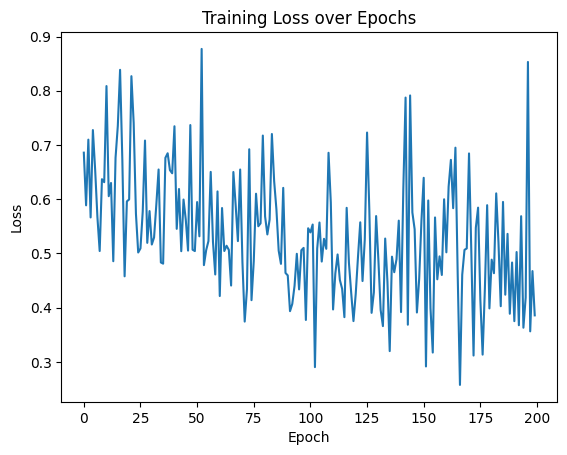

In [16]:
# Plotting the training loss
print(len(losses))
plt.plot(range(len(losses)), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [17]:
import torch
# Convert the scaled test data into tensors (outside the function since it will remain constant)
X_val_tensor = torch.tensor(X_val_scaled.astype(np.float32))
y_val_tensor = torch.tensor(y_val.values.astype(np.float32)).view(-1, 1)

def evaluate_model(model):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        outputs = model(X_val_tensor)
        predicted = (outputs > 0.5).float()  # Using 0.5 as the threshold
        accuracy = (predicted == y_val_tensor).float().mean()
        return accuracy


In [18]:
# Evaluate the model
accuracy = evaluate_model(base_model)
print(f'Accuracy: {accuracy.item():.4f}')

Accuracy: 0.8049


## Applying GridSearch Algo to find best hyperparameters and evaluate on validation dataset

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.init as init
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix,accuracy_score

losses = []
# Define the training function
def train_model(model, train_loader, criterion, optimizer, epochs=50,debug = False):
    
    model.train()  
    
    global losses
    losses.clear()
    
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
    
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        losses.append(loss.item())
        
        if debug:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}')


In [20]:
# Define the evaluation function
def evaluate_model_for_recall(model, X_val_tensor, y_val_tensor):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = model(X_val_tensor)
        predicted = (outputs > 0.5).float()
        recall = recall_score(y_val_tensor.numpy(), predicted.numpy())
        return recall


In [21]:
# Define the function to perform manual hyperparameter search
def hyperparameter_search_with_recall(train_loader, X_val_tensor, y_val_tensor, input_dim, param_grid):
    best_params = None
    best_recall = 0.0
    
    for param in param_grid:

        new_model = Perceptron(input_dim=input_dim)
        if param['optimizer'] == 'SGD':
            optimizer = optim.SGD(new_model.parameters(), lr=param['learning_rate'])
        elif param['optimizer'] == 'Adam':
            optimizer = optim.Adam(new_model.parameters(), lr=param['learning_rate'])
        
        if param['weight_init'] == 'xavier':
            init.xavier_uniform_(new_model.fc.weight)
        elif param['weight_init'] == 'he':
            init.kaiming_uniform_(new_model.fc.weight, nonlinearity='relu')
        
        print(f"\nTraining with params: {param}")
        train_model(new_model, train_loader, nn.BCELoss(), optimizer, epochs=param['epochs'],debug = False)
        
        recall = evaluate_model_for_recall(new_model, X_val_tensor, y_val_tensor)
        print(f"Validation Recall: {recall:.4f}")
        
        if recall > best_recall:
            best_recall = recall
            best_params = param
    
    return best_params, best_recall



In [22]:

# Parameter grid for hyperparameter search
param_grid = [
    {'optimizer': 'SGD', 'learning_rate': 0.001, 'epochs': 200, 'weight_init': 'xavier'},
    {'optimizer': 'SGD', 'learning_rate': 0.0001, 'epochs': 200, 'weight_init': 'xavier'},
    {'optimizer': 'Adam', 'learning_rate': 0.001, 'epochs': 200, 'weight_init': 'xavier'},
    {'optimizer': 'Adam', 'learning_rate': 0.0001, 'epochs': 200, 'weight_init': 'he'},
    {'optimizer': 'SGD', 'learning_rate': 0.0001, 'epochs': 300, 'weight_init': 'xavier'},
    {'optimizer': 'Adam', 'learning_rate': 0.0001, 'epochs': 300, 'weight_init': 'xavier'},
    {'optimizer': 'SGD', 'learning_rate': 0.001, 'epochs': 400, 'weight_init': 'xavier'},
    {'optimizer': 'SGD', 'learning_rate': 0.0001, 'epochs': 400, 'weight_init': 'xavier'},
    {'optimizer': 'Adam', 'learning_rate': 0.001, 'epochs': 500, 'weight_init': 'xavier'},
    {'optimizer': 'Adam', 'learning_rate': 0.0001, 'epochs': 500, 'weight_init': 'he'},
    {'optimizer': 'SGD', 'learning_rate': 0.0001, 'epochs': 400, 'weight_init': 'xavier'},
    {'optimizer': 'Adam', 'learning_rate': 0.0001, 'epochs': 500, 'weight_init': 'xavier'},
]

# Perform hyperparameter search based on recall
best_params, best_recall = hyperparameter_search_with_recall(train_loader, X_val_tensor, y_val_tensor, X_train.shape[1], param_grid)



Training with params: {'optimizer': 'SGD', 'learning_rate': 0.001, 'epochs': 200, 'weight_init': 'xavier'}
Validation Recall: 0.6744

Training with params: {'optimizer': 'SGD', 'learning_rate': 0.0001, 'epochs': 200, 'weight_init': 'xavier'}
Validation Recall: 0.6279

Training with params: {'optimizer': 'Adam', 'learning_rate': 0.001, 'epochs': 200, 'weight_init': 'xavier'}
Validation Recall: 0.6512

Training with params: {'optimizer': 'Adam', 'learning_rate': 0.0001, 'epochs': 200, 'weight_init': 'he'}
Validation Recall: 0.5814

Training with params: {'optimizer': 'SGD', 'learning_rate': 0.0001, 'epochs': 300, 'weight_init': 'xavier'}
Validation Recall: 0.5814

Training with params: {'optimizer': 'Adam', 'learning_rate': 0.0001, 'epochs': 300, 'weight_init': 'xavier'}
Validation Recall: 0.6744

Training with params: {'optimizer': 'SGD', 'learning_rate': 0.001, 'epochs': 400, 'weight_init': 'xavier'}
Validation Recall: 0.6977

Training with params: {'optimizer': 'SGD', 'learning_rate'

In [23]:
print(f"Best Parameters: {best_params}")
print(f"Best Validation Recall: {best_recall:.4f}")

Best Parameters: {'optimizer': 'SGD', 'learning_rate': 0.0001, 'epochs': 400, 'weight_init': 'xavier'}
Best Validation Recall: 0.7674


In [40]:
new_model2 = Perceptron(input_dim=X_train.shape[1])
criterion = nn.BCELoss()  
optimizer = optim.Adam(new_model2.parameters(), lr=0.0001) 
init.xavier_uniform_(new_model2.fc.weight)

Parameter containing:
tensor([[-0.6800,  0.4806, -0.2935,  0.3130,  0.5776, -0.5104, -0.7585,  0.6153]],
       requires_grad=True)

## Training model on best hyperparameters found after gridsearch algorithm and testing on test dataset (Model 2)

In [41]:
train_model(new_model2, train_loader, criterion, optimizer, epochs=400 ,debug=False)

400


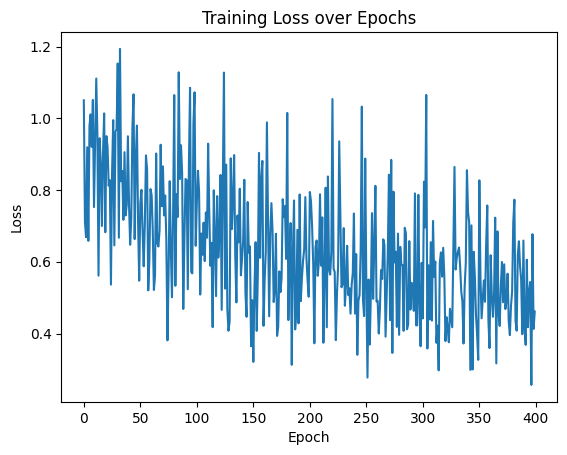

In [42]:
# Plotting the training loss
print(len(losses))
plt.plot(range(len(losses)), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

## Testing the new trained model with best parameters on test dataset 

In [43]:
# Convert the scaled test data into tensors (outside the function since it will remain constant)
X_test_tensor = torch.tensor(X_test_scaled.astype(np.float32))
y_test_tensor = torch.tensor(y_test.values.astype(np.float32)).view(-1, 1)

def evaluate_model(model):
    model.eval() 
    with torch.no_grad():  
        outputs = model(X_test_tensor)
        predicted = (outputs > 0.5).float()  
        accuracy = (predicted == y_test_tensor).float().mean()
        return accuracy

In [44]:
evaluate_model(new_model2)

tensor(0.7273)

In [45]:
def evaluate_classification_model(model):

    model.eval()

    with torch.no_grad():
        outputs = model(X_test_tensor)
        predicted = (outputs > 0.5).float().numpy()

    y_val_np = y_test_tensor.numpy()

    accuracy = accuracy_score(y_val_np, predicted)
    precision = precision_score(y_val_np, predicted)
    recall = recall_score(y_val_np, predicted)
    f1 = f1_score(y_val_np, predicted)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    
    cm = confusion_matrix(y_val_np, predicted)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

Accuracy: 0.7273
Precision: 0.6250
Recall: 0.5556
F1 Score: 0.5882


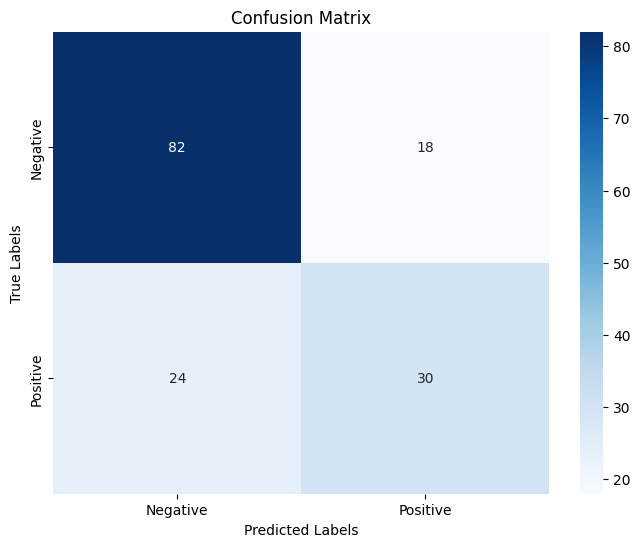

In [46]:
import seaborn as sns
# Call the function to evaluate the model and visualize results
evaluate_classification_model(new_model2)

## Reducing the features using PCA,retrain the model and evaluate on testing dataset(Model 3)

In [31]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)

In [32]:
X_train2 = pca.fit_transform(X_train)
X_test2 = pca.transform(X_test)

In [33]:
X_test.shape

(154, 8)

In [34]:
X_train_scaled2 = scaler.fit_transform(X_train2)

X_test_scaled2 = scaler.transform(X_test2)

X_train_tensor2 = torch.tensor(X_train_scaled2.astype(np.float32))
y_train_tensor2 = torch.tensor(y_train.values.astype(np.float32)).view(-1, 1)

train_dataset2 = TensorDataset(X_train_tensor2, y_train_tensor2)
train_loader2 = DataLoader(dataset=train_dataset2, batch_size=16, shuffle=True)

In [35]:
new_model3 = Perceptron(input_dim=X_train2.shape[1])
criterion = nn.BCELoss()  
optimizer = optim.Adam(new_model3.parameters(), lr=0.0001) 
init.xavier_uniform_(new_model3.fc.weight)

train_model(new_model3, train_loader2, criterion, optimizer, epochs=500)

Accuracy: 0.6883
Precision: 0.5882
Recall: 0.3704
F1 Score: 0.4545


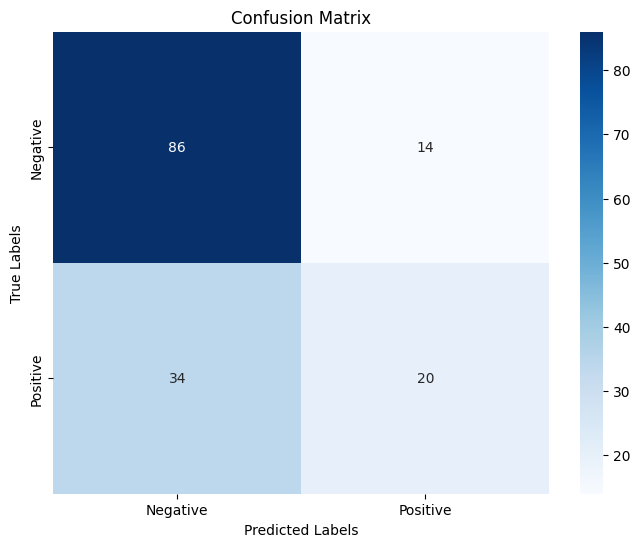

In [36]:
import seaborn as sns

X_test_tensor2 = torch.tensor(X_test_scaled2.astype(np.float32))
y_test_tensor2 = torch.tensor(y_test.values.astype(np.float32)).view(-1, 1)

new_model3.eval()

with torch.no_grad():
    outputs = new_model3(X_test_tensor2)
    predicted = (outputs > 0.5).float().numpy()

y_val_np = y_test_tensor2.numpy()

# Calculate accuracy, prcision, recall, and F1 score
accuracy = accuracy_score(y_val_np, predicted)
precision = precision_score(y_val_np, predicted)
recall = recall_score(y_val_np, predicted)
f1 = f1_score(y_val_np, predicted)

# Print accuracy, precision, recall, and F1 score
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Calculate confusion matrix
cm = confusion_matrix(y_val_np, predicted)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Applying L2 Regularization and retrain the model and evaluate on testing dataset(Model 4)

In [37]:
from torch.optim.lr_scheduler import ExponentialLR

new_model4 = Perceptron(input_dim=X_train.shape[1])
criterion = nn.BCELoss()

l2_lambda = 0.01  
optimizer = optim.SGD(new_model4.parameters(), lr=0.0001, weight_decay=l2_lambda)

scheduler = ExponentialLR(optimizer, gamma=0.9)  

new_model4.train()  

losses = []
epochs = 1000

for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        outputs = new_model4(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Append average loss for the epoch
    losses.append(running_loss / len(train_loader))
    #scheduler.step()

print("Training Over..")


Training Over..


1000


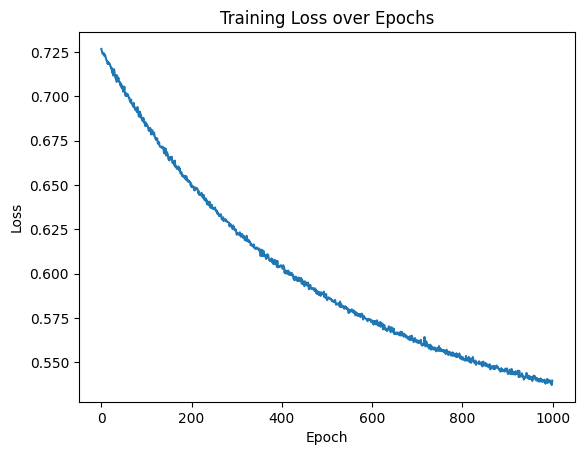

In [38]:
# Plotting the training loss
print(len(losses))
plt.plot(range(len(losses)), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

Accuracy: 0.7273
Precision: 0.6304
Recall: 0.5370
F1 Score: 0.5800


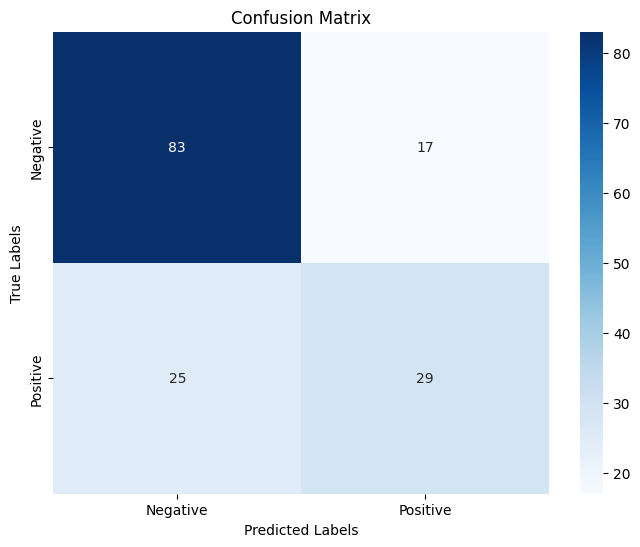

In [39]:
new_model4.eval()

with torch.no_grad():
    outputs = new_model4(X_test_tensor)
    predicted = (outputs > 0.5).float().numpy()

y_test_np = y_test_tensor.numpy()

accuracy = accuracy_score(y_test_np, predicted)
precision = precision_score(y_test_np, predicted)
recall = recall_score(y_test_np, predicted)
f1 = f1_score(y_test_np, predicted)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

cm = confusion_matrix(y_test_np, predicted)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
!https://github.com/Manusinh-Thakor/Assignment_1-Deep-Learning.git